In [2]:
import os
import sys
sys.path.append('./lib')


import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from model import PDFmodel

In [27]:
WEIGHTS_TOKEN = 'weights.h5'
def select_weight(epoch: int):
  return f"epoch_{int(epoch)}.{WEIGHTS_TOKEN}"

In [28]:
FIT_FOLDER = Path('./fits/test')

In [163]:
replicas_folders = [f for f in FIT_FOLDER.iterdir() if f.is_dir() and 'replica' in str(f)]
replicas_folders.sort()
data_by_replica = {replica_folder.name: np.load(replica_folder / 'data.npy')  for replica_folder in replicas_folders}
replicas = len(replicas_folders)

# For each replicas, load the epochs and data
replica_epochs_dict = {}
for replica_folder in replicas_folders:
  epochs = [f for f in replica_folder.iterdir() if f.is_file() and WEIGHTS_TOKEN in str(f)]
  epochs.sort()
  replica_epochs_dict[replica_folder.name] = epochs

In [110]:
# Find common epochs
common_epochs = set()
for replica, epochs in replica_epochs_dict.items():
  aux = set()
  for epoch in epochs:
    epoch_num = int(epoch.name.split('.')[0].split('_')[1])
    aux.add(epoch_num)
  
  if len(common_epochs) == 0:
    common_epochs = aux
  else:
    common_epochs.intersection_update(aux)

common_epochs = sorted(list(common_epochs))
print(f"Common epochs: {common_epochs}")

Common epochs: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800]


In [139]:
class Distribution():
  def __init__(self, name):
    self.name = name
    self.__data = []
  
  def add(self, data):
    self.__data.append(data)

  def get_mean(self, axis=0):
    return np.mean(self.__data, axis=axis)
  
  def get_std(self, axis=0):
    return np.std(self.__data, axis=axis)
  
  def get_data(self):
    return np.array(self.__data)
  
  def set_data(self, data):
    self.__data = data

  def __str__(self):
    return f"{self.name}:\n{self.__data}"
  
  def __repr__(self):
    return self.__str__()
  
  def __len__(self):
    return len(self.__data)

  def __getitem__(self, key):
    return self.__data[key]

In [140]:
PDF = Distribution('PDF')
for replica_path in replicas_folders:
    replica = replica_path.name
    last_epoch = replica_epochs_dict[replica][-1]

    print(f'Loading replica{replica_path.name.replace("replica_", "")} ...')
    model = PDFmodel.load_model(replica_path / 'config.json', last_epoch)
    PDF.add(model.predict().numpy().reshape(-1))
    print(' Done!')


Loading replica1 ...
 Done!
Loading replica2 ...
 Done!
Loading replica3 ...
 Done!
Loading replica4 ...
 Done!
Loading replica5 ...
 Done!
Loading replica6 ...
 Done!
Loading replica7 ...
 Done!


In [141]:
fk_grid = np.load('Tommaso/fk_grid.npy')
data = np.load('Tommaso/data.npy')
FK = np.load('Tommaso/FK.npy')
f_bcdms = np.load('Tommaso/f_bcdms.npy')
Cy = np.load('Tommaso/Cy.npy')
Cinv = np.linalg.inv(Cy)
y = FK @ f_bcdms

[]

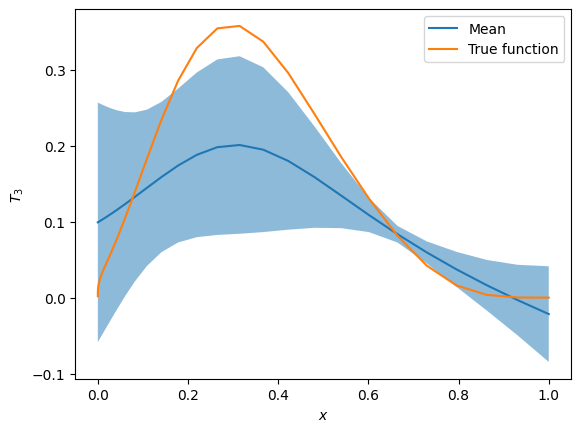

In [142]:
plt.plot(model.inputs.numpy().reshape(-1), PDF.get_mean(), label='Mean')
plt.fill_between(model.inputs.numpy().reshape(-1), PDF.get_mean() - PDF.get_std(), PDF.get_mean() + PDF.get_std(), alpha=0.5)
plt.plot(fk_grid, f_bcdms, label='True function')
plt.xlabel(r'$x$')
plt.ylabel(r'$T_3$')
plt.legend()
plt.plot()

In [143]:
# Collect NTK distributions for each replica
NTK_time = []
for epoch in common_epochs:
  NTK_distribution = Distribution(f'NTK epoch {epoch}')
  for replica_path in replicas_folders:
    model = PDFmodel.load_model(replica_path / 'config.json', replica_path / select_weight(epoch))
    NTK = model.compute_ntk()
    NTK_distribution.add(NTK)
  NTK_time.append(NTK_distribution)

In [146]:
# Compute distributions for NTK eigenvalues
frob_norm_time = []
l2_norm_time = []
for l in range(len(NTK_time)):
  frob_norm_dist = Distribution(f'Frobenius norm epoch {common_epochs[l]}')
  l2_norm_dist = Distribution(f'L2 norm epoch {common_epochs[l]}')
  for rep in range(len(NTK_time[l])):
    ntk = NTK_time[l][rep]
    frob_norm_dist.add(np.linalg.norm(ntk, ord='fro'))
    l2_norm_dist.add(np.linalg.norm(ntk, ord=2))

  frob_norm_time.append(frob_norm_dist)
  l2_norm_time.append(l2_norm_dist)

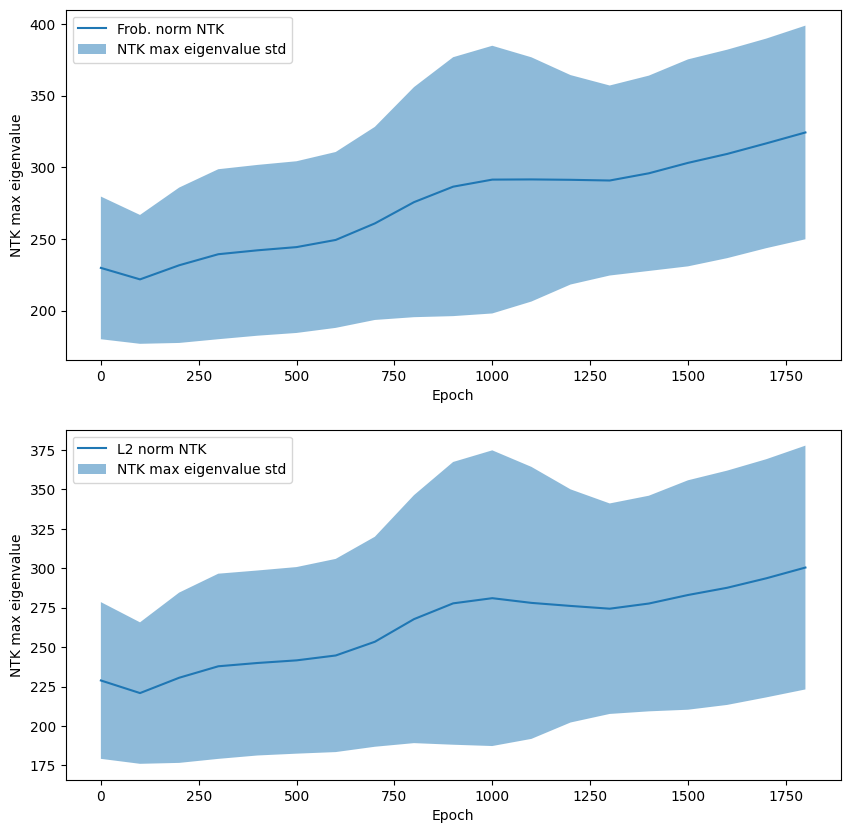

In [153]:
frob_means = np.array([frob.get_mean() for frob in frob_norm_time])
frob_stds = np.array([frob.get_std() for frob in frob_norm_time])
l2_means = np.array([l2.get_mean() for l2 in l2_norm_time])
l2_stds = np.array([l2.get_std() for l2 in l2_norm_time])

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(common_epochs, frob_means, label='Frob. norm NTK')
axs[0].fill_between(common_epochs, frob_means + frob_stds, frob_means - frob_stds, alpha=0.5, label='NTK max eigenvalue std')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('NTK max eigenvalue')
axs[0].legend()

axs[1].plot(common_epochs, l2_means, label='L2 norm NTK')
axs[1].fill_between(common_epochs, l2_means + l2_stds, l2_means - l2_stds, alpha=0.5, label='NTK max eigenvalue std')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('NTK max eigenvalue')
axs[1].legend()

In [155]:
data = np.load(FIT_FOLDER / 'replica_89/data.npy')